# Self-Driving Car Engineer Nanodegree


## Project 4: **Advanced Lane Finding** 
***
This project focuses on finding lane lines and lane line curvature in a video stream using the lessons learned in Udacity Self Driving Nano-Degree Program. 

Major steps to develop the lane line detection algorithm include:
- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

## Import Packages
Packages from matplotlib, numpy, cv2, math and os libraries are used in this program:

In [1]:
# Importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import math
import os
import glob
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Calibrating the Camera

In [2]:
# Defineing the undistorting function using cv2.undistort
def cal_undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [3]:
# Defining the camera calibration function
def calibrate_camera(calibration_images, nx=9, ny=6):
    
    # Arrays to store object and image points
    objpoints = []  # 3D point in world
    imgpoints = []  # 2D points in image
    
    # Prepare object points
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    
    for fname in calibration_images:
        
        img = mpimg.imread(fname)
        
        # Grayscale the image
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist

##  Example of Distortion-Corrected Image

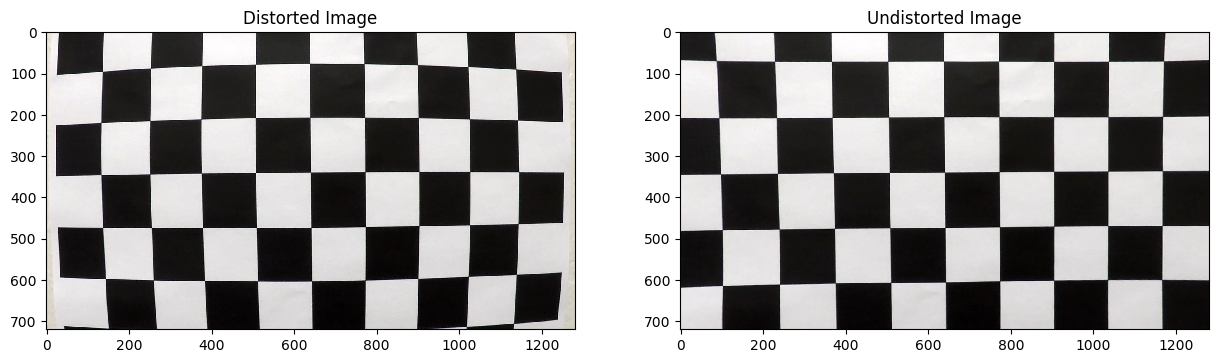

In [4]:
# Calibrating the camera

# Chessboard size
nx = 9
ny = 6

# Path for the calibration files
calibration_path = './camera_cal/calibration*.jpg'
calibration_images = glob.glob(calibration_path )

# Calibrate Camera
global mtx, dist
mtx, dist = calibrate_camera(calibration_images, nx, ny)

# Applying undistortion on a test image
image =  mpimg.imread('camera_cal/calibration1.jpg')

plt.figure(figsize=(15, 10), dpi=100)

plt.subplot(1,2,1)
plt.title('Distorted Image')
plt.imshow(image)

image = cal_undistort(image, mtx, dist)

plt.subplot(1,2,2)
plt.title('Undistorted Image')
plt.imshow(image)

## Color and Gradient Thresholding
In this section, color and gradinet thresholding functions are defined to generate the binary image with clearly visible lane lines. 

In [5]:
def abs_sobel_threshold(img, orient='x', sobel_kernel=3, abs_thresh=(0,255)):
    # Convert to grayscale
    # gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= abs_thresh[0]) & (scaled_sobel <= abs_thresh[1])] = 1

    # Return the result
    return binary_output

In [6]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_threshold(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale

    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [7]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, dir_thresh=(0, np.pi/2)):
    # Grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output

In [8]:
# Define combined thresholding
def combined_threshold(img, abs_thresh=(0, 255), mag_thresh=(0, 255), dir_thresh=(0, np.pi/2)):

    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements
    
    # Apply each of the thresholding functions
    gradx_binary = abs_sobel_threshold(img, orient='x', sobel_kernel=ksize, abs_thresh=(60, 255))  
    mag_binary = mag_threshold(img, sobel_kernel=9, mag_thresh=(80, 255))
    dir_binary = dir_threshold(img, sobel_kernel=15, dir_thresh=(0.8, 1.3))  
    
    combined_binary = np.zeros_like(dir_binary)
    combined_binary[(gradx_binary == 1) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined_binary

In [9]:
# Define a function that thresholds the S-channel of HLS
def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

## Defining Lane Class to Track Fitted Polynomials

In [10]:
class Line():
    def __init__(self):
        self.averaging_size = 15
        # was the line detected in the last iteration?
        self.detected = False
        self.error_counter = 0  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = None 
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

    def update(self, fit_coeffs, curv):
        if (self.radius_of_curvature != None):
            # ignore the finding if the new curve is very different than the existing one
            if (abs(curv - self.radius_of_curvature)/self.radius_of_curvature > 7):
                self.detected = False;
                self.error_counter = self.error_counter + 1
                if (self.error_counter < 3):
                    return
            else:
                self.error_counter = 0
                self.detected = True

        self.radius_of_curvature = curv
       
        self.current_fit = fit_coeffs
        if self.best_fit == None or (self.error_counter >= 3 and self.detected == False):
            self.best_fit = np.array(self.current_fit)
            self.error_counter = 0
        elif len(self.recent_xfitted) == self.averaging_size:
            del self.recent_xfitted[0]

        self.recent_xfitted.append(fit_coeffs)
        self.best_fit = np.mean( np.array(self.recent_xfitted), axis=0 )

## Perspective Transformation

In [11]:
global src, dst, M, Minv

src = np.float32(
        [[570,460],
         [725, 460],
         [1200, 720],
         [100, 720]])
    
dst = np.float32(
        [[105,0],
         [1105,0],
         [1105,720],
         [105, 720]])

M    = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

def warp(img, M):
    img_size = (img.shape[1], img.shape[0]) 
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warped

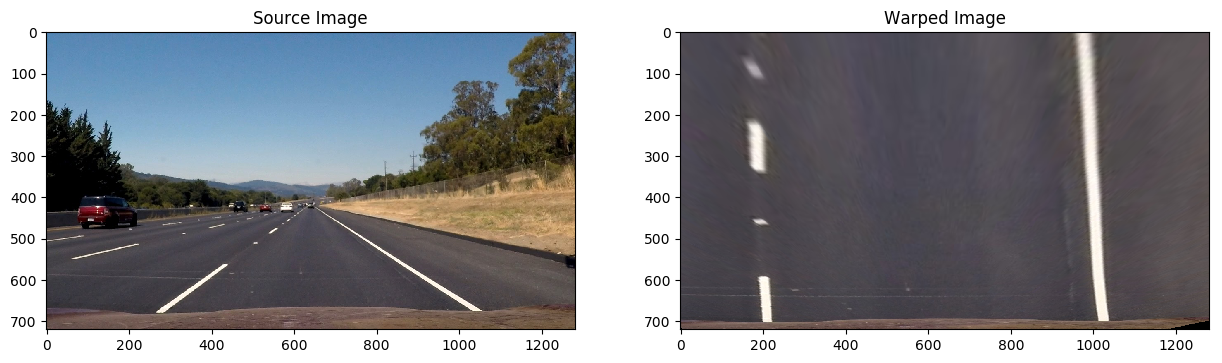

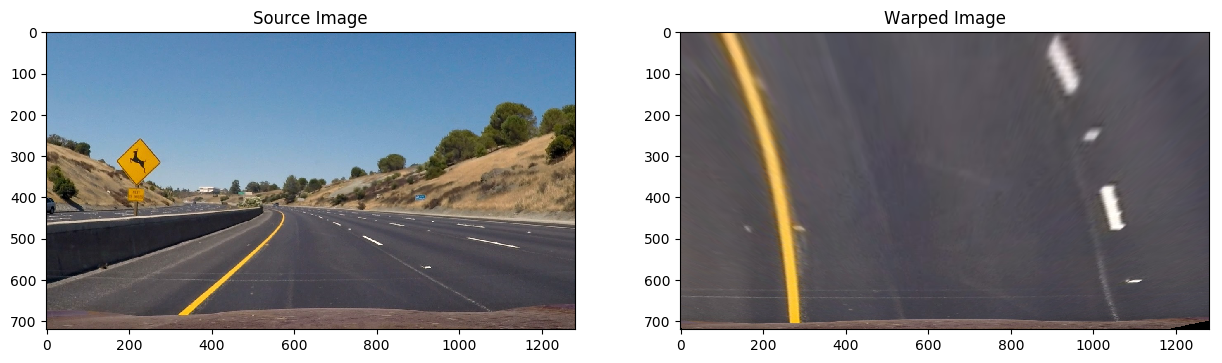

In [12]:
image =  mpimg.imread('test_images/straight_lines2.jpg')

plt.figure(figsize=(15, 10), dpi=100)
plt.subplot(1,2,1)
plt.title('Source Image')
plt.imshow(image)

image = warp(image, M)
plt.subplot(1,2,2)
plt.title('Warped Image')
plt.imshow(image)

image =  mpimg.imread('test_images/test2.jpg')

plt.figure(figsize=(15, 10), dpi=100)
plt.subplot(1,2,1)
plt.title('Source Image')
plt.imshow(image)

image = warp(image, M)
plt.subplot(1,2,2)
plt.title('Warped Image')
plt.imshow(image)

## Defining Region of Interest in the Image

In [13]:
global reg_vertices
imshape = image.shape  
X = imshape[1]
Y = imshape[0]
region_bl = (0,Y*0.90)
region_tl = (0.35*X, 0.65*Y)
region_br = (0.65*X, 0.65*Y)
region_tr = (X,Y*0.90)
reg_vertices = np.array([[region_bl,region_tl,region_br,region_tr]], dtype=np.int32)

In [14]:
def region_of_interest(img, reg_vertices):
   
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, reg_vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

## Identifying Lane Line Pixles and Fitting with Polynomial

In [15]:
def find_lines(binary_warped, left_fit = None, right_fit=None):
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    if(left_fit == None and right_fit==None):
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[np.int(binary_warped.shape[0]/2):,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Choose the number of sliding windows
        nwindows = 9
        
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        
        # Set the width of the windows +/- margin
        margin = 70
        
        # Set minimum number of pixels found to recenter window
        minpix = 30
        
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        
        # Step through the windows one by one
        for window in range(nwindows):
            
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
    else:
        margin = 70
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                          (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                           (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
        
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
  
    return left_fit, right_fit, leftx, lefty, rightx, righty, ploty

In [16]:
def visualize(binary_warped, left_fit, right_fit, lefty, leftx, righty, rightx):
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    margin = 70
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    
    # Color in left and right line pixels
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.figure(figsize = (15,20))
    plt.title("Destination Points and Polynomials", fontsize=20)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.show()
    return result

## Calculating the Curvature and Distance to Center of the Lane

In [17]:
def calc_curvature(leftx, lefty, rightx, righty, ploty):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Now our radius of curvature is in meters
    return left_curverad, right_curverad

In [18]:
def calc_dist_to_center(xleft, xcenter, xright):
    xm_per_pix = 3.7/700  # meters per pixel in x dimension
    dist_to_center = xm_per_pix * ((xleft+xright)/2. - xcenter)
    return dist_to_center

## Pipeline to Identify Lane Lines

In [19]:
def pipeline(image, show_image_flag):
    
    # Originalimage
    if show_image_flag == 1:
        plt.figure(figsize = (15,20))
        plt.title("Original Image", fontsize=20)
        plt.imshow(image)
        plt.show()    
    
    # Undistort the image
    image = cal_undistort(image, mtx, dist)
    if show_image_flag == 1:
        plt.figure(figsize = (15,20))
        plt.title("Undistorted Image", fontsize=20)
        plt.imshow(image)
        plt.show()

    # Convert to Grayscale image
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Grayscale Threshold
    gray_binary = np.zeros_like(gray)
    gray_binary[gray >= 200] = 1
    if show_image_flag == 1:
        plt.figure(figsize = (15,20))
        plt.title("Binary Image After Grayscaling", fontsize=20)
        plt.imshow(gray_binary)
        plt.show()

    
    # Absolute Sobel Threshold
    abs_sobel_binary = abs_sobel_threshold(gray, 'x', 3, (60, 100))
    if show_image_flag == 1:
        plt.figure(figsize = (15,20))
        plt.title("Binary Image After Absolute Threshold", fontsize=20)
        plt.imshow(abs_sobel_binary)
        plt.show()

    # Magnitude of Sobel Threshold
    mag_binary = mag_threshold(gray, 3, (80, 225))
    if show_image_flag == 1:
        plt.figure(figsize = (15,20))
        plt.title("Binary Image After Magnitude of Threshold", fontsize=20)
        plt.imshow(mag_binary)
        plt.show()

    # Directioal Threshold
    dir_binary = dir_threshold(gray, 3, (0.8, 1.3))
    if show_image_flag == 1:
        plt.figure(figsize = (15,20))
        plt.title("Binary Image After Directional Threshold", fontsize=20)
        plt.imshow(dir_binary)
        plt.show()

    # Combined Threshold
    combined_binary = combined_threshold(gray, abs_thresh=(60,100), mag_thresh=(80,255), dir_thresh=(0.8, 1.3))
    if show_image_flag == 1:
        plt.figure(figsize = (15,20))
        plt.title("Binary Image After Absolute, Directional and Magnitude Threshold", fontsize=20)
        plt.imshow(combined_binary)
        plt.show()

    # HLS Threshold
    hls_binary = hls_select(image, thresh=(180, 255))
    if show_image_flag == 1:
        plt.figure(figsize = (15,20))
        plt.title("Binary Image After HLS Threshold", fontsize=20)
        plt.imshow(hls_binary)
        plt.show()
    
    
    # Combining all Thresholds
    combined = np.zeros_like(gray)
    combined[(gray_binary == 1) | (combined_binary == 1) | (hls_binary == 1)] = 1
    if show_image_flag == 1:
        plt.figure(figsize = (15,20))
        plt.title("Binary Image After Combined Threshold", fontsize=20)
        plt.imshow(combined)
        plt.show()

    # Combined with Region of Interest
    combined = region_of_interest(combined, reg_vertices)
    if show_image_flag == 1:
        plt.figure(figsize = (15,20))
        plt.title("Binary Image After Combined Threshold and Applying Region of Interest", fontsize=20)
        plt.imshow(combined)
        plt.show()
    
    # Transfer perspective to birds eye view
    binary_warped = warp(combined, M)
    if show_image_flag == 1:
        plt.figure(figsize = (15,20))
        plt.title("Birds Eye View of the Image After Thresholds and Region of Interest", fontsize=20)
        plt.imshow(binary_warped)
        plt.show()
    
    
    # Find lane lines 
    left_fit, right_fit, leftx, lefty, rightx, righty, ploty = find_lines(binary_warped)
    
    # Visualize the Lane Lines
    if show_image_flag == 1:
        visualize(binary_warped, left_fit, right_fit, lefty, leftx, righty, rightx)
    
    # Calculate Curvature of lane lines
    left_curve_rad, right_curve_rad = calc_curvature(leftx, lefty, rightx, righty, ploty)

    # Calculate distance to center
    dist_to_center = calc_dist_to_center(leftx[-1], image.shape[1]/2, rightx[-1])

    # Perform Sanity checks
    if (min(left_curve_rad , right_curve_rad) > 300):
        left_lane.update(left_fit, left_curve_rad)
        right_lane.update(right_fit, right_curve_rad)
        
    left_fit = left_lane.best_fit
    right_fit = right_lane.best_fit
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))   
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # Print curvature and the distance to center on the image
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    fontColor = (255,255,255)
    lineType = 2
    cv2.putText(result,'Left Curvature = ' + str(left_lane.radius_of_curvature) + ' m',
    (10,50), font, fontScale, fontColor, lineType)
    cv2.putText(result,'Right Curvature = ' + str(right_lane.radius_of_curvature) + ' m',
    (10,100), font, fontScale, fontColor, lineType)
    cv2.putText(result,'Distance to Center = ' + str(dist_to_center) + ' m',
    (10,150), font, fontScale, fontColor, lineType)
    
    return result

## Example Image of Results for Identifying the Lane Lines

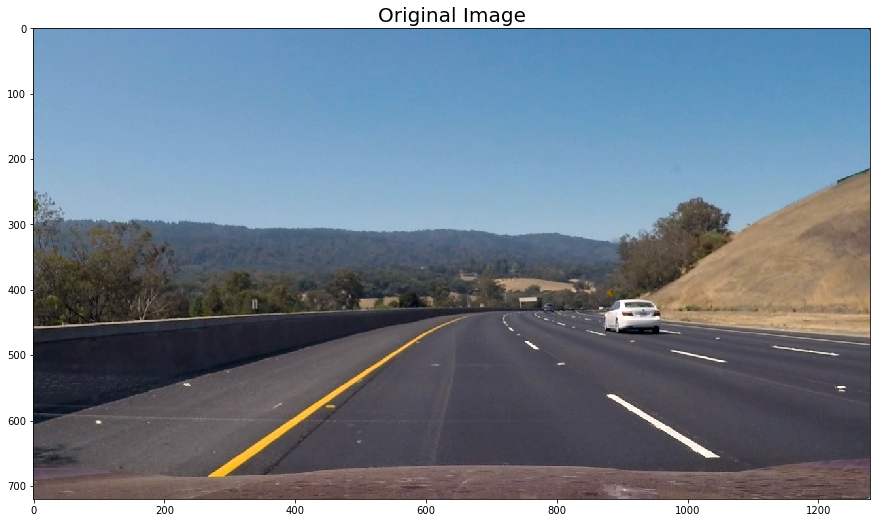

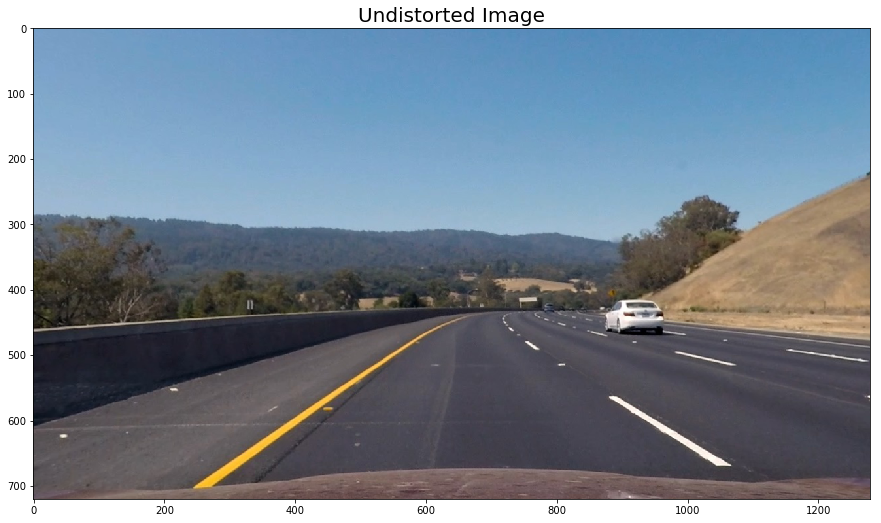

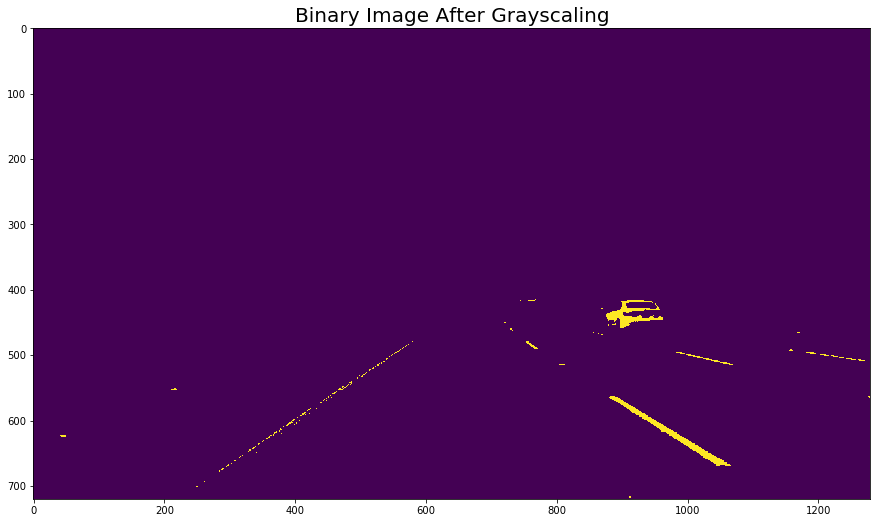

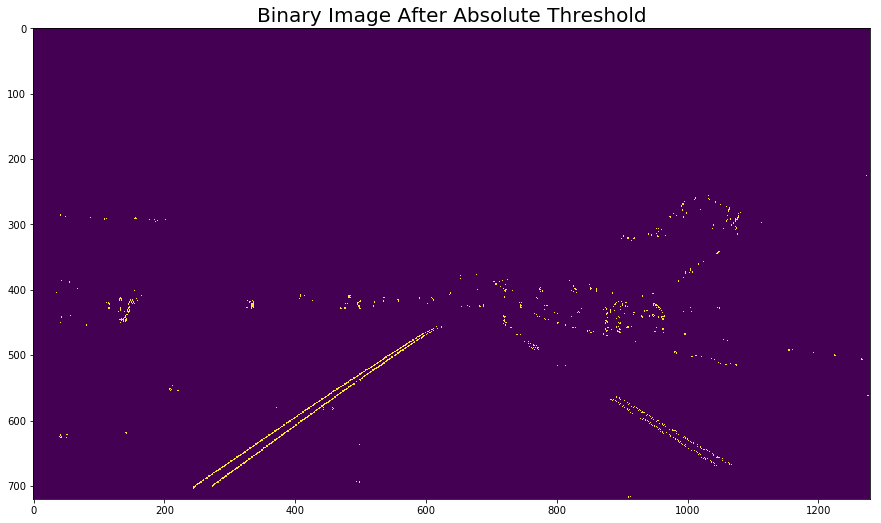

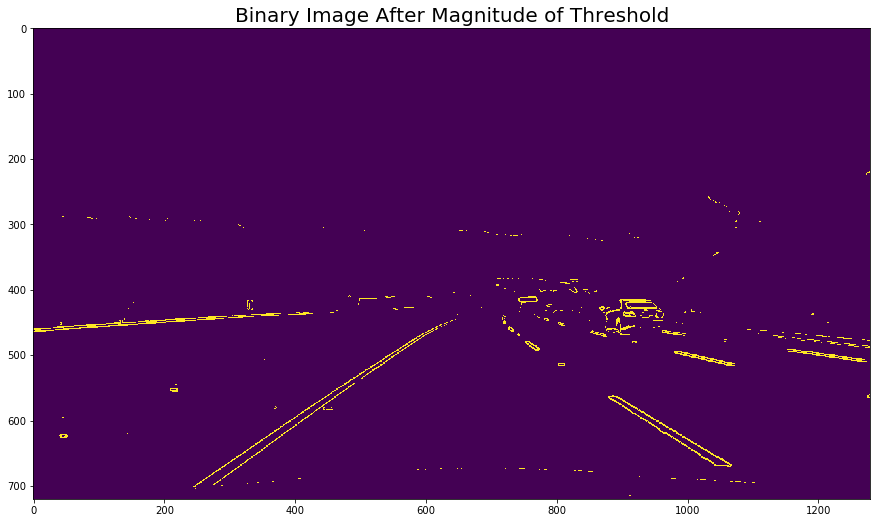

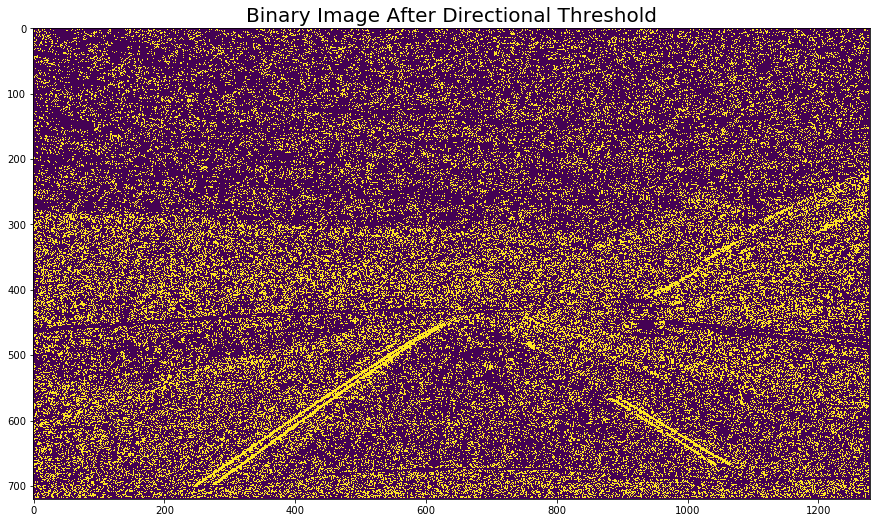

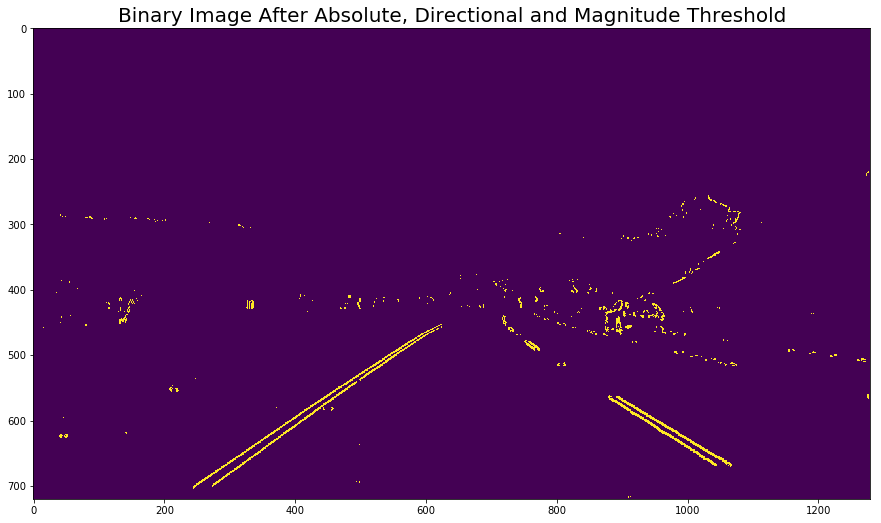

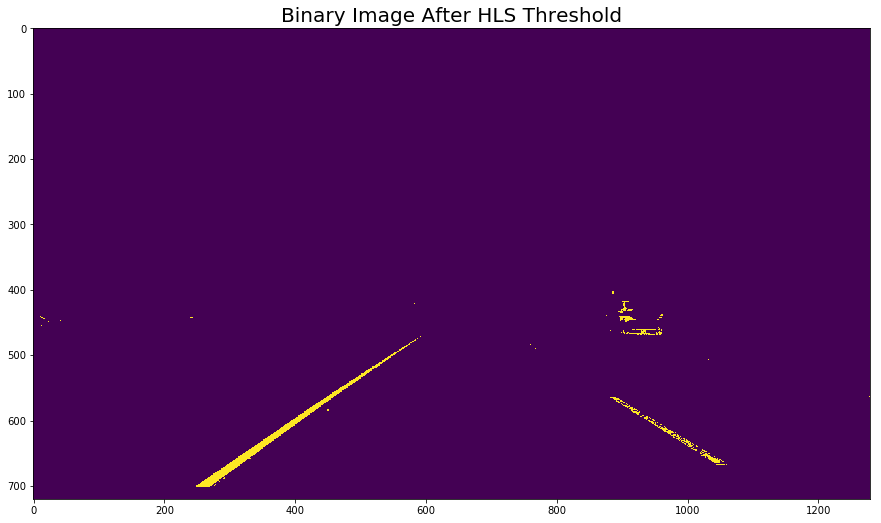

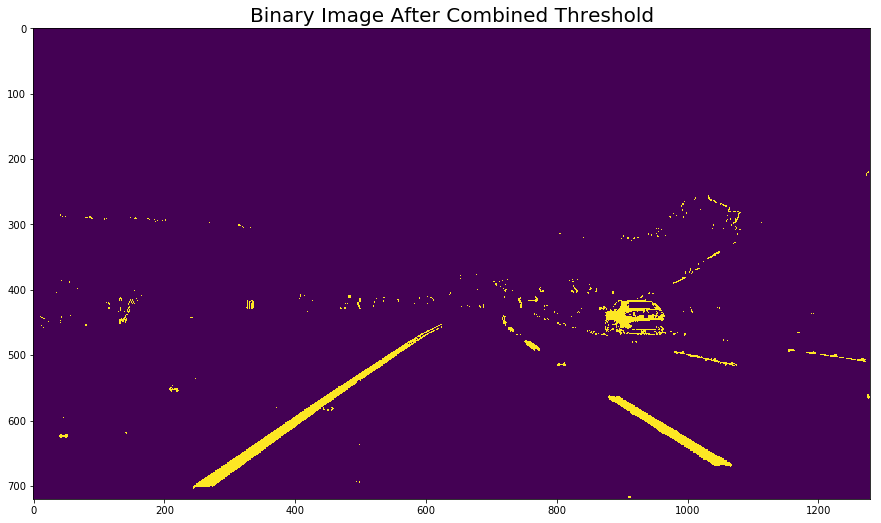

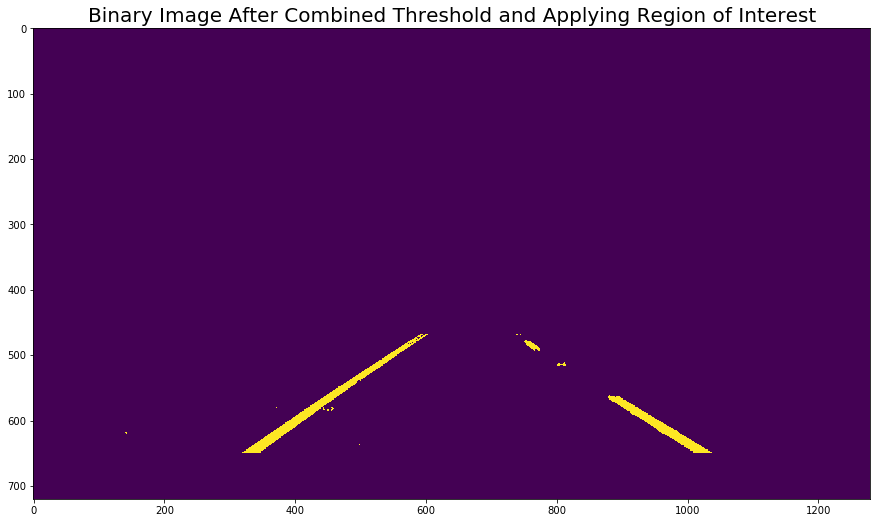

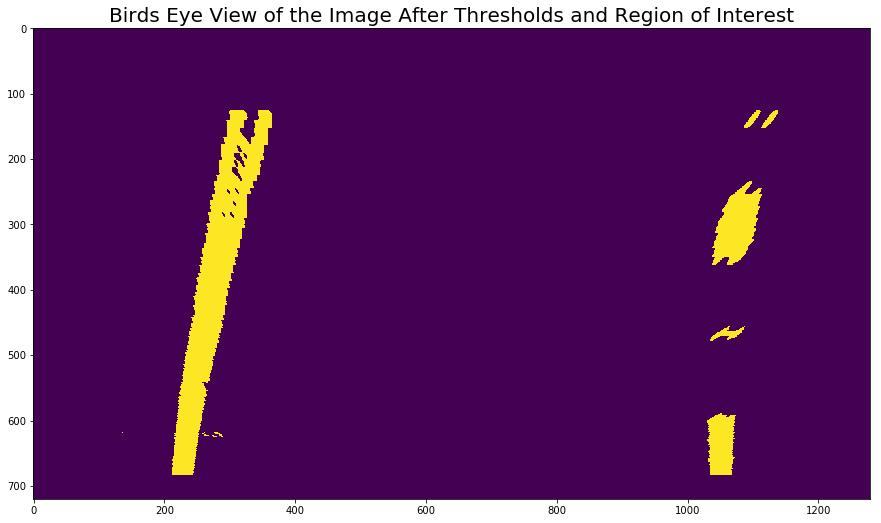

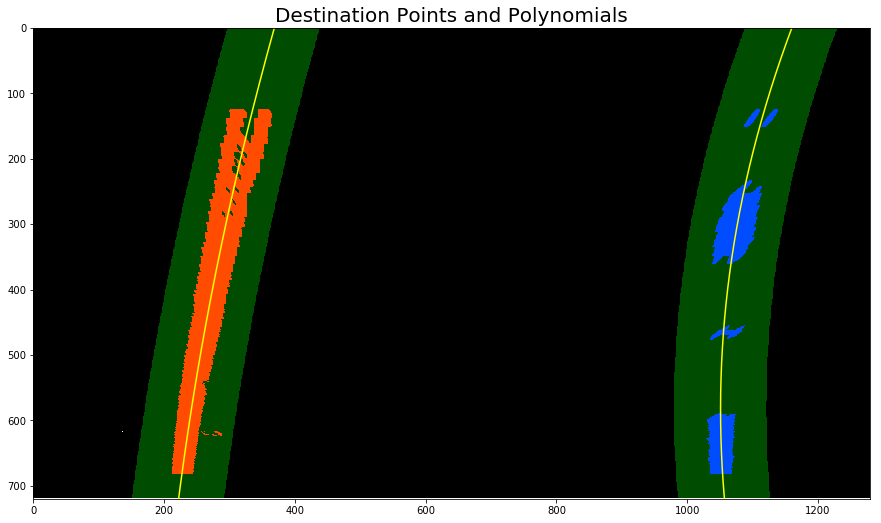

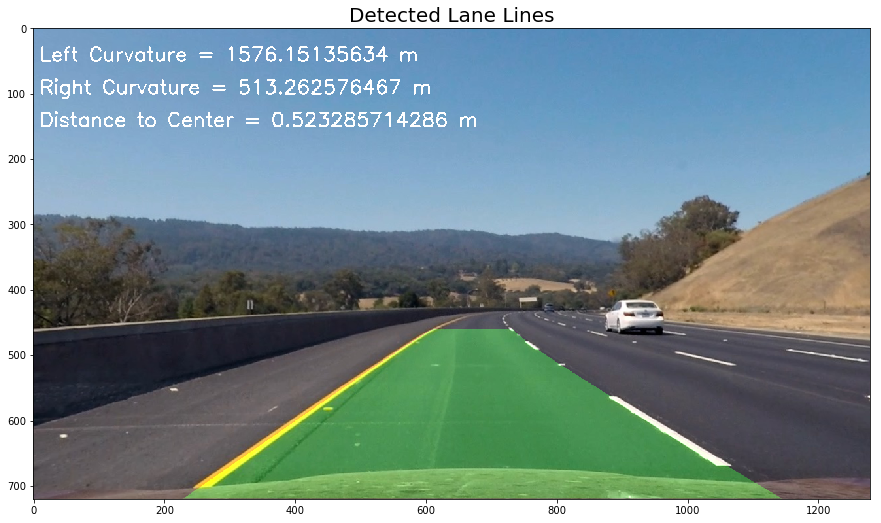

In [20]:
#lane objects
left_lane = Line()
right_lane = Line()
    
image = mpimg.imread('test_images/test3.jpg')
result =  pipeline(image, 1)

plt.figure(figsize = (15,20))
plt.title("Detected Lane Lines", fontsize=20)
plt.imshow(result)
plt.show()

## Processing the Video Stream Using the Pipeline
The pipeline is used to fine the lane lines on the video stream from the camera
    

In [21]:
def process_image(image):
    result = pipeline(image, 0)
    return result

In [22]:
test_output_file = 'project_video_output.mp4'
clip_test = VideoFileClip("project_video.mp4")
clip_test_out = clip_test.fl_image(process_image) #NOTE: this function expects color images!!
%time clip_test_out.write_videofile(test_output_file, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [06:19<00:00,  3.40it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 6min 20s


In [23]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_output_file))